In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("Datasets/SPY_10years.csv", index_col="Date", parse_dates=True)


In [2]:
data.info()
#data.drop(['Dividends', 'Stock Splits', "Capital Gains"], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2245 entries, 2014-01-02 to 2022-11-30
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               2245 non-null   float64
 1   High               2245 non-null   float64
 2   Low                2245 non-null   float64
 3   Close              2245 non-null   float64
 4   Adj Close          2245 non-null   float64
 5   Volume             2245 non-null   int64  
 6   SMA_5              2245 non-null   float64
 7   SMA_20             2245 non-null   float64
 8   SMA_50             2245 non-null   float64
 9   SMA_252            2245 non-null   float64
 10  daily_return       2245 non-null   float64
 11  monthly_return     2245 non-null   float64
 12  adv20              2245 non-null   float64
 13  VWAP               2245 non-null   float64
 14  log_returns        2245 non-null   float64
 15  volatility_30      2245 non-null   float64
 16  volati

In [3]:
#Split train, test
scaler = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))

target = scaler.fit_transform(data["Close"].values.reshape(-1, 1))
features = scaler.fit_transform(data.drop(["Close"], axis=1))

data = pd.DataFrame(pd.concat([pd.DataFrame(features), pd.DataFrame(target)], axis=1))
train, test = data.iloc[:int(len(data) * 0.7),:], data.iloc[int(len(data) * 0.7):len(data), :]

In [4]:
# Normalizing the data
def create_window(data, window_size=1):
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis=1)

    data.dropna(axis=0, inplace=True)
    return (data)



def reconstruct_data(data, n=1):
    x, y = [], []
    for i in range(len(data) - n - 1):
        x.append(data.iloc[i:(i + n), :])
        #append close price
        y.append(data.iloc[i + n, 3])

    return (np.array(x), np.array(y))

train_x, train_y = reconstruct_data(train, 5)
test_x, test_y = reconstruct_data(test, 5)

#print(train_x.shape, train_y.shape)


In [5]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print(train.shape)


(1565, 5, 19) (1565,)
(668, 5, 19) (668,)
(1571, 19)


In [6]:
# Changing it into rnn input shape ([samples, time steps, features])


#train_x = np.reshape(
#    train_x, (train_x.shape[0], 1, 5* 18))
#test_x = np.reshape(
#    test_x, (test_x.shape[0], 1, 5 * 18))
print(train_x.shape)
print(test_x.shape)


(1565, 5, 19)
(668, 5, 19)


In [7]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

from keras import callbacks
def model_lstm(window, features):

    #current best
    model4 = Sequential()
    model4.add(LSTM(300, input_shape=(window, features), return_sequences=True))
    model4.add(Dropout(0.5))
    model4.add(LSTM(200, input_shape=(window, features), return_sequences=True))
    model4.add(Dropout(0.5))
    model4.add(LSTM(100, input_shape=(window, features), return_sequences=False))
    model4.add(Dropout(0.5))
    model4.add(Dense(1))
    model4.compile(loss='mse', optimizer='adam')
    
    #test model
    model = Sequential()
    model.add(LSTM(100, input_shape=(window, features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(50, input_shape=(window, features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(25, input_shape=(window, features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    return model
    
    #return model4


earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=10,
                                        restore_best_weights=True)


In [14]:
fold = 1
model = model_lstm(5, 19)

for train_index, val_index in tscv.split(train):
    print(f"Fold {fold}")
    print(f"Training from index: 0 to {max(train_index)}")	
    print(f"Validating from index {max(train_index)} to {max(val_index)}")
    train_data, val_data = train[:max(train_index)], train[max(train_index):]
    
    train_data_x, train_data_y = reconstruct_data(train_data, 5)
    val_data_x, val_data_y = reconstruct_data(val_data, 5)
    print(train_data_x.shape, train_data_y.shape)

    
    train_data_x = np.reshape(
        train_data_x, (train_data_x.shape[0], train_data_x.shape[1], train_data_x.shape[2]))
    val_data_x = np.reshape(
        val_data_x, (val_data_x.shape[0], val_data_x.shape[1], val_data_x.shape[2]))
    
    history = model.fit(train_data_x, train_data_y, epochs=500, batch_size=12, 
                        validation_data=(val_data_x, val_data_y),
                        verbose=0, callbacks=[], shuffle=False)
    

    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    fold += 1


Fold 1
Training from index: 0 to 265
Validating from index 265 to 526
(259, 5, 19) (259,)


KeyboardInterrupt: 

In [9]:
#train_x = np.reshape(
#    train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2]))
#test_x = np.reshape(
#    test_x, (test_x.shape[0], test_x.shape[1], test_x.shape[2]))


#history = model.fit(train_x, train_y, epochs=100, batch_size=24, validation_data=(test_x, test_y),
#                    verbose=0, callbacks=[], shuffle=False)



#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper right')
#plt.show()


In [10]:
test_loss = model.evaluate(test_x, test_y)
print("Test Loss:", test_loss)


21/21 [==============================] - 0s 4ms/step - loss: 0.1596
Test Loss: 0.15964607894420624


49/49 [==============================] - 2s 4ms/step


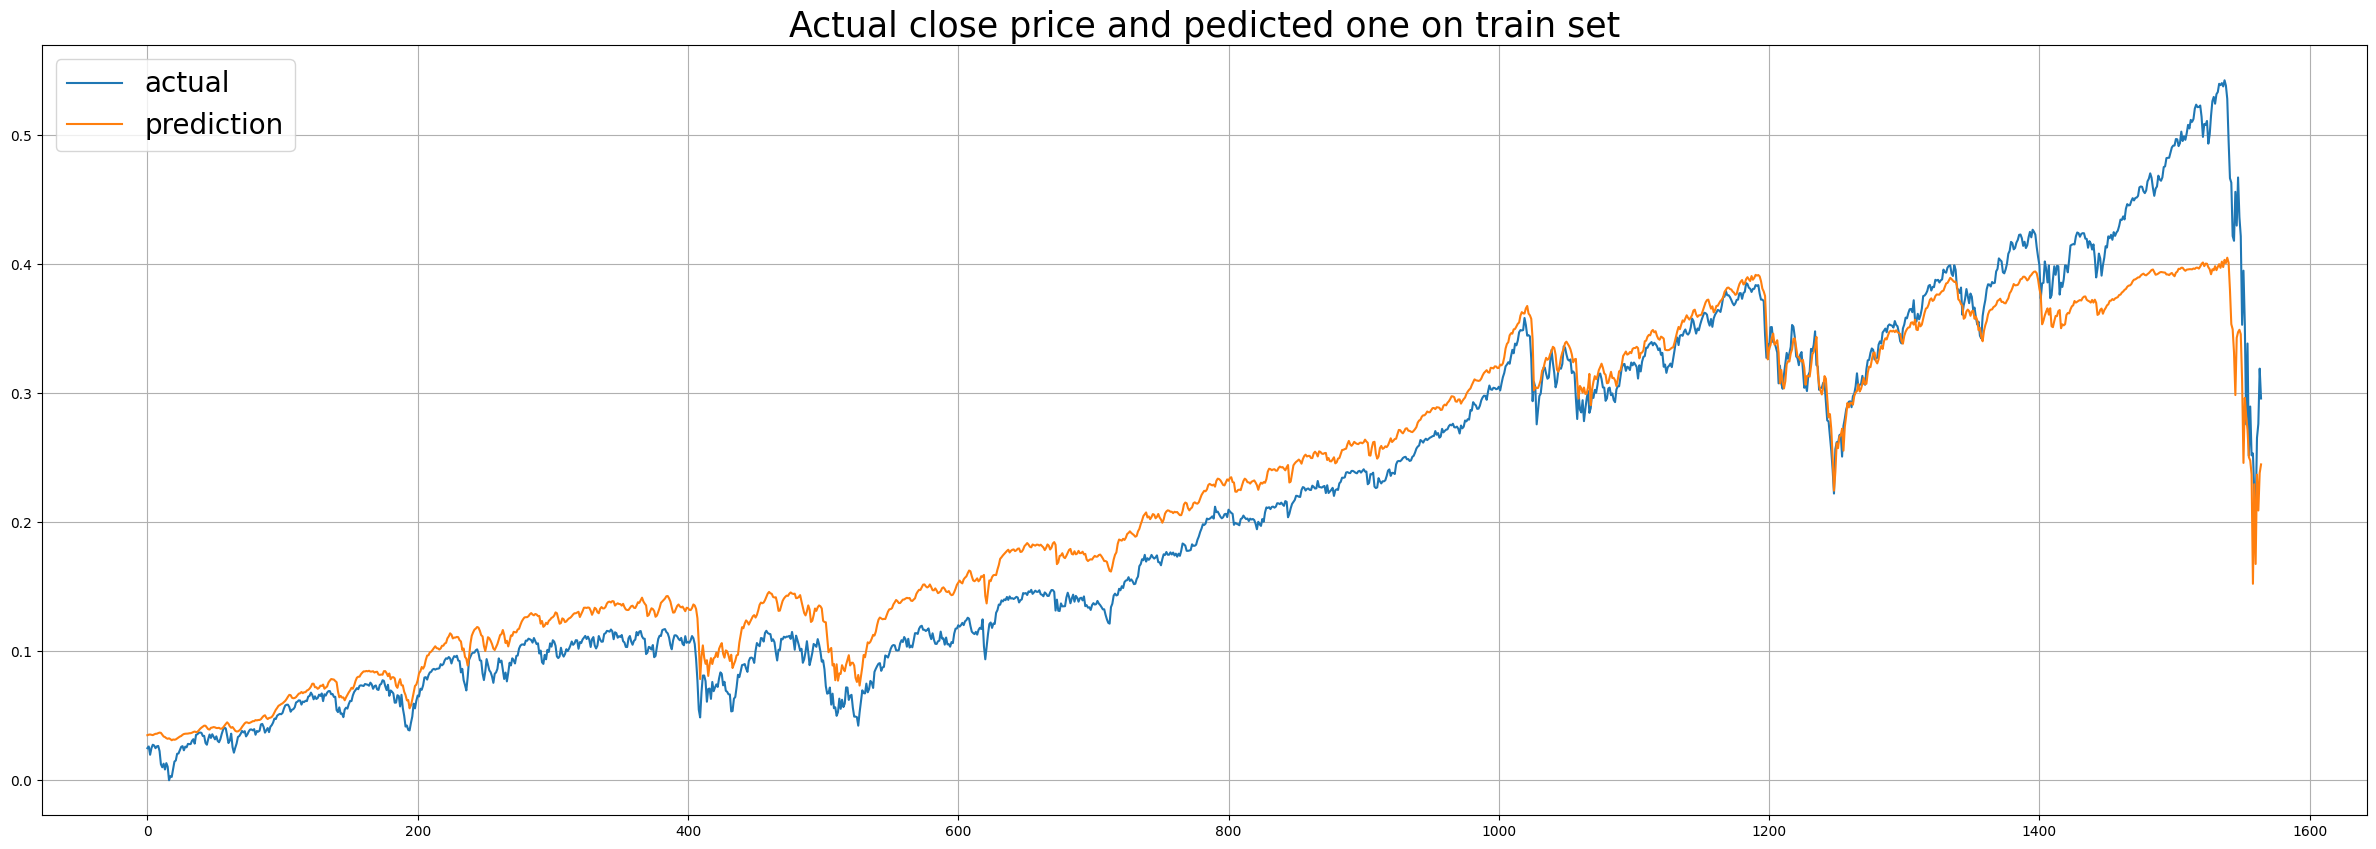

In [11]:
y_predicted=model.predict(train_x)

#unscaled_predicted = scaler.inverse_transform(y_predicted)

plt.figure(figsize=(30, 10))
plt.plot(train_y, label="actual")
plt.plot(y_predicted, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual close price and pedicted one on train set", fontsize=25)
plt.show()


21/21 [==============================] - 0s 4ms/step


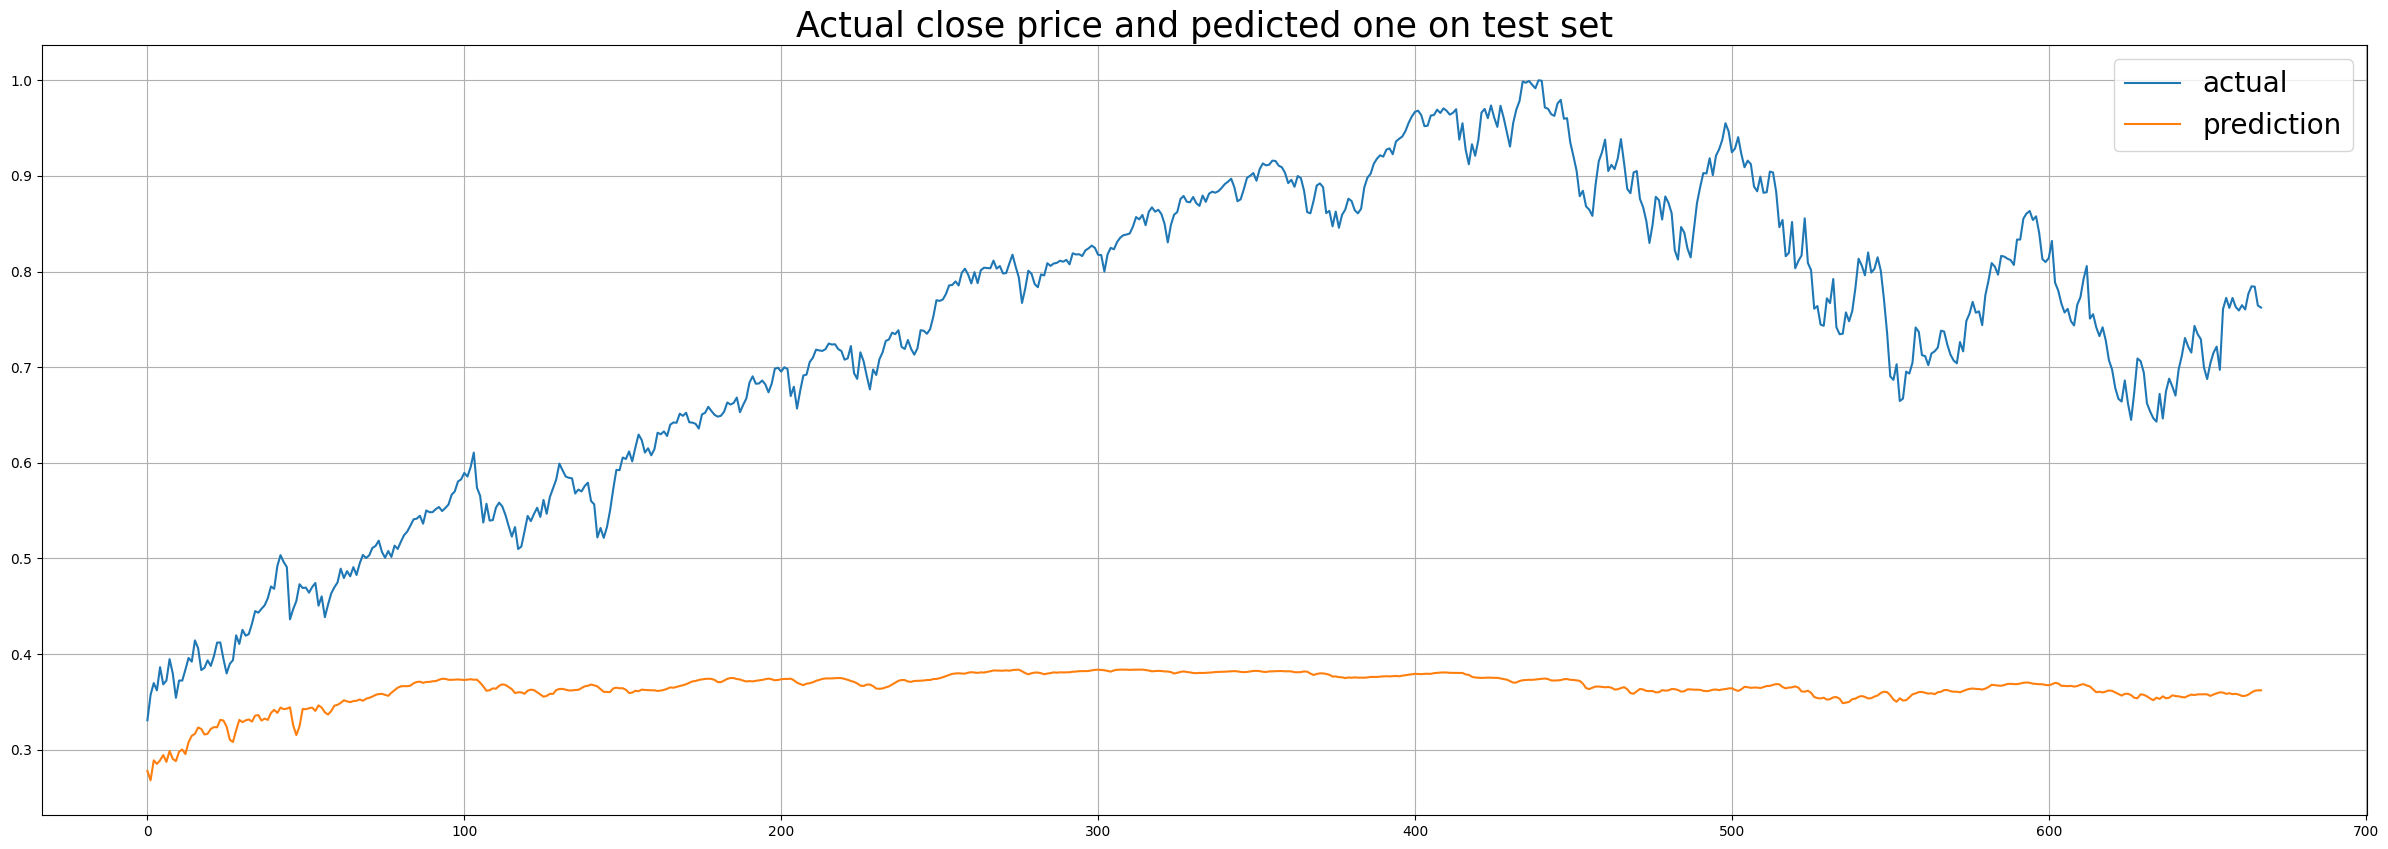

In [12]:
#Predicting Testing Dataset
test_predict = model.predict(test_x)
#test_predict = scaler.inverse_transform(test_predict)
#test_labels = scaler.inverse_transform(test_y)

plt.figure(figsize=(30, 10))
plt.plot(test_y, label="actual")
plt.plot(test_predict, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual close price and pedicted one on test set", fontsize=25)
plt.show()


In [13]:
#Summary Statistics 
